# Общая информация:
__Задачи, решаемые в ноутбуке:__

Взять NER модель обученной на SO и произвести определение сушностей в title и body

1) Изучить возможноые классы NER

2) Выделить NER в title и body, сохранить информацию об их количестве

3) Вызодные файлы df_200.csv и df_200.pkl

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install bert_score datasets rouge_score evaluate pynvml transformers wandb sentence-transformers
    
    !wget https://raw.githubusercontent.com/Myashka/Diploma/master/Notebooks/utils.py

    from utils import *

    from google.colab import drive
    drive.mount("/content/drive")
else:
    import sys
    sys.path.append(r"D:\vkr\Notebooks")

    from utils import *

In [51]:
import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", None)

from tqdm.auto import tqdm
import torch
from transformers import (AutoModelForTokenClassification, AutoTokenizer, pipeline)
from sentence_transformers import SentenceTransformer

import warnings
warnings.filterwarnings("ignore")

In [2]:
torch.manual_seed(42)
np.random.seed(42)

# Загрузка данных

In [3]:
df = pd.read_pickle(r'D:\vkr\data\df_200.pkl')
df = df.reset_index(drop=True)

In [4]:
from ast import literal_eval
df.loc[:, 'Tag'] = df.loc[:, 'Tag'].apply(lambda x: literal_eval(x))

ValueError: malformed node or string: ['android', 'android-4.2-jelly-bean']

# NER

## Загрузка модели NER

In [8]:
device = torch.device("cuda") if torch.cuda.is_available else "cpu"

In [9]:
tokenizer = AutoTokenizer.from_pretrained("mrm8488/codebert-base-finetuned-stackoverflow-ner")
model = AutoModelForTokenClassification.from_pretrained("mrm8488/codebert-base-finetuned-stackoverflow-ner")
tagger = pipeline('ner', model=model, tokenizer=tokenizer, grouped_entities=True, aggregation_strategy='average')

## Возможные тэги

In [76]:
print(*model.config.id2label.values(), sep='\n')

-
--
----
B-Algorithm
B-Application
B-Class
B-Code_Block
B-Data_Structure
B-Data_Type
B-Device
B-Error_Name
B-File_Name
B-File_Type
B-Function
B-HTML_XML_Tag
B-Keyboard_IP
B-Language
B-Library
B-Licence
B-Operating_System
B-Organization
B-Output_Block
B-User_Interface_Element
B-User_Name
B-Value
B-Variable
B-Version
B-Website
I-Algorithm
I-Application
I-Class
I-Code_Block
I-Data_Structure
I-Data_Type
I-Device
I-Error_Name
I-File_Name
I-File_Type
I-Function
I-HTML_XML_Tag
I-Keyboard_IP
I-Language
I-Library
I-Licence
I-Operating_System
I-Output_Block
I-User_Interface_Element
I-User_Name
I-Value
I-Variable
I-Version
I-Website
MAIN
--MEDIA
O


## Добавление NER в df

Функция для объединения "сущностей" в один элемент (сущности одного класса, score считается как средний из сложенных)

In [10]:
def parse_ner(model_entities):
    new_entities = []
    if len(model_entities) == 1:
        return model_entities
    for i in range(len(model_entities)):
        count = 2
        if i == 0:
            new_entities.append(model_entities[i])
        else:
            if (
                new_entities[-1]["end"] == model_entities[i]["start"]
                #and new_entities[-1]["entity_group"] == model_entities[i]["entity_group"]
            ):
                new_entities[-1] = {
                    "entity_group": new_entities[-1]["entity_group"],
                    "score": (
                        new_entities[-1]["score"] * (count - 1) + model_entities[i]["score"]
                    )
                    / count,
                    "word": new_entities[-1]["word"] + model_entities[i]["word"],
                    "start": new_entities[-1]["start"],
                    "end": model_entities[i]["end"],
                }
                count += 1
            else:
                new_entities.append(model_entities[i])
    return new_entities

In [11]:
idx = 6
print(f"question: {df.Q_Body.values[idx]}")

output = tagger(df["Q_Body"].values[idx])
print(*parse_ner(output), sep='\n')

question: How can we integrate Flurry to Admobs or AdWhirl Mediation ?? Is we cant Flurry using Webpage then, do we need to add it using Code ? I am working in Android, how can we do that?
{'entity_group': 'Library', 'score': 0.8431235551834106, 'word': ' Flurry', 'start': 21, 'end': 27}
{'entity_group': 'Application', 'score': 0.8715477, 'word': ' Adm', 'start': 31, 'end': 34}
{'entity_group': 'Application', 'score': 0.5604931, 'word': 'Wh', 'start': 43, 'end': 45}
{'entity_group': 'Library', 'score': 0.7668567299842834, 'word': ' Flurry', 'start': 73, 'end': 79}
{'entity_group': 'Application', 'score': 0.98689765, 'word': ' Webpage', 'start': 86, 'end': 93}
{'entity_group': 'Operating_System', 'score': 0.9949568, 'word': ' Android', 'start': 150, 'end': 157}


In [11]:
def get_count_entities(text):
    output = tagger(text)
    try:
        return len(parse_ner(output))
    except:
        return 0

Q_entities и T_entities - list of dicts

In [13]:
df['Q_entities'] = df.Q_Body.apply(lambda x: parse_ner(tagger(x)))

In [14]:
df['T_entities'] = df.Q_Title.apply(lambda x: parse_ner(tagger(x)))

In [24]:
df['Q_entities_count'] = df.Q_entities.apply(lambda x: len(x))
df['T_entities_count'] = df.T_entities.apply(lambda x: len(x))

In [25]:
df.columns

Index(['Id', 'Q_date_open', 'Q_Score', 'Q_Title', 'Q_Body', 'A_Score',
       'A_Body', 'Tag', 'Q_len', 'A_len', 'API_CHANGE', 'API_USAGE',
       'CONCEPTUAL', 'DISCREPANCY', 'DOCUMENTATION', 'ERRORS', 'REVIEW',
       't_q_BERT_dist', 't_q_MPnet_dist', 'Q_entities_count',
       'T_entities_count', 'Q_entities', 'T_entities'],
      dtype='object')

<AxesSubplot:xlabel='Q_len', ylabel='Q_entities_count'>

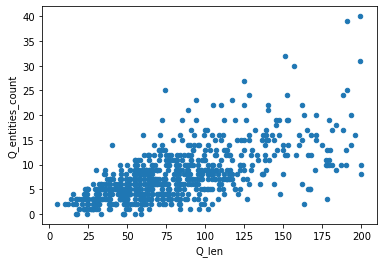

In [26]:
df.plot.scatter('Q_len', 'Q_entities_count')

# Анализ количества классов сущностей

## Counting entities in titles and questions

In [27]:
df.columns

Index(['Id', 'Q_date_open', 'Q_Score', 'Q_Title', 'Q_Body', 'A_Score',
       'A_Body', 'Tag', 'Q_len', 'A_len', 'API_CHANGE', 'API_USAGE',
       'CONCEPTUAL', 'DISCREPANCY', 'DOCUMENTATION', 'ERRORS', 'REVIEW',
       't_q_BERT_dist', 't_q_MPnet_dist', 'Q_entities_count',
       'T_entities_count', 'Q_entities', 'T_entities'],
      dtype='object')

In [68]:
#df = df.drop(columns=['API_CHANGE', 'API_USAGE', 'CONCEPTUAL', 'DISCREPANCY', 'DOCUMENTATION', 'ERRORS', 'REVIEW',])

In [73]:
print(*model.config.id2label.values(), sep='|||')

-|||--|||----|||B-Algorithm|||B-Application|||B-Class|||B-Code_Block|||B-Data_Structure|||B-Data_Type|||B-Device|||B-Error_Name|||B-File_Name|||B-File_Type|||B-Function|||B-HTML_XML_Tag|||B-Keyboard_IP|||B-Language|||B-Library|||B-Licence|||B-Operating_System|||B-Organization|||B-Output_Block|||B-User_Interface_Element|||B-User_Name|||B-Value|||B-Variable|||B-Version|||B-Website|||I-Algorithm|||I-Application|||I-Class|||I-Code_Block|||I-Data_Structure|||I-Data_Type|||I-Device|||I-Error_Name|||I-File_Name|||I-File_Type|||I-Function|||I-HTML_XML_Tag|||I-Keyboard_IP|||I-Language|||I-Library|||I-Licence|||I-Operating_System|||I-Output_Block|||I-User_Interface_Element|||I-User_Name|||I-Value|||I-Variable|||I-Version|||I-Website|||MAIN|||--MEDIA|||O


In [28]:
labels = list(model.config.id2label.values())

new_labels = []
for label in labels:
    if label.startswith('B-') or label.startswith('I-'):
        new_labels.append(label[2:])

Посмотрим возможные классы сущностей

In [29]:
new_labels = sorted(list(set(new_labels)))

In [31]:
for i, label in enumerate(new_labels):
    print(label, end=' |||') 
    if i % 5 == 4: 
        print("\n")

Algorithm |||Application |||Class |||Code_Block |||Data_Structure |||

Data_Type |||Device |||Error_Name |||File_Name |||File_Type |||

Function |||HTML_XML_Tag |||Keyboard_IP |||Language |||Library |||

Licence |||Operating_System |||Organization |||Output_Block |||User_Interface_Element |||

User_Name |||Value |||Variable |||Version |||Website |||



## Посчитаем количество сущностей разных классов в title и question

In [32]:
for label in new_labels:
    df[f'Q_{label}'] = 0

In [33]:
for label in new_labels:
    df[f'T_{label}'] = 0

In [34]:
for index, row in tqdm(df.loc[df.Q_entities_count != 0].iterrows()):
    for ent in row.Q_entities:
        if ent['entity_group'] in new_labels:
            col = 'Q_'+ent['entity_group']
            df.at[index, col] += 1

0it [00:00, ?it/s]

In [35]:
for index, row in tqdm(df.loc[df.T_entities_count != 0].iterrows()):
    for ent in row.T_entities:
        if ent['entity_group'] in new_labels:
            col = 'T_'+ent['entity_group']
            df.at[index, col] += 1

0it [00:00, ?it/s]

In [36]:
df.to_csv(r'../../data/df_200_continuous.csv')

In [37]:
df.to_pickle(r'../../data/df_200_continuous.pkl')

In [38]:
df.iloc[:, -25:].describe()

,T_Algorithm,T_Application,T_Class,T_Code_Block,T_Data_Structure,T_Data_Type,T_Device,T_Error_Name,T_File_Name,T_File_Type,...,T_Licence,T_Operating_System,T_Organization,T_Output_Block,T_User_Interface_Element,T_User_Name,T_Value,T_Variable,T_Version,T_Website
count,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,...,707.0,707.000000,707.0,707.000000,707.000000,707.0,707.000000,707.000000,707.000000,707.000000
mean,0.002829,0.333805,0.173975,0.015559,0.011315,0.011315,0.159830,0.021216,0.039604,0.055163,...,0.0,0.521924,0.0,0.008487,0.171146,0.0,0.022631,0.036775,0.043847,0.012730
std,0.053149,0.586947,0.466439,0.134801,0.105845,0.118474,0.417295,0.201558,0.234705,0.257600,...,0.0,0.551087,0.0,0.106110,0.479452,0.0,0.197856,0.252590,0.236956,0.112186
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,1.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
max,1.000000,3.000000,3.000000,2.000000,1.000000,2.000000,2.000000,3.000000,3.000000,2.000000,...,0.0,3.000000,0.0,2.000000,5.000000,0.0,3.000000,4.000000,2.000000,1.000000


Количество классов сущностей в датасете

In [ ]:
for label in [
    "Algorithm",
    "Application",
    "Class",
    "Code_Block",
    "Data_Structure",
    "Data_Type",
    "Device",
    "Error_Name",
    "File_Name",
    "File_Type",
    "Function",
    "HTML_XML_Tag",
    "Keyboard_IP",
    "Language",
    "Library",
    "Licence",
    "Operating_System",
    "Organization",
    "Output_Block",
    "User_Interface_Element",
    "User_Name",
    "Value",
    "Variable",
    "Version",
    "Website",
]:
    print(f'{label}: '+str(sum(df[f'{label}'].value_counts()[1:])))


## Посмотрим выбросы (обычный НЕР и "тянущийся" НЕР)

In [12]:
# check by hands 
df.loc[df[f'T_Keyboard_IP'] != 0].loc[:, ['Q_Title', 'T_Keyboard_IP']]

,Q_Title,T_Keyboard_IP
77,"Android: Localized standard Text for example OK, CANCEL and GPS not activated - for example?",1


Посмотрим классы NER, которых в датасете очень мало, вероятнее всего это неверно определенные NER

In [327]:
df = pd.read_pickle(r'D:\vkr\data\prepared\df_200_continuous_ner_cleared.pkl')

In [328]:
ner_cols = [
    "Q_Algorithm",
    "Q_Application",
    "Q_Class",
    "Q_Code_Block",
    "Q_Data_Structure",
    "Q_Data_Type",
    "Q_Device",
    "Q_Error_Name",
    "Q_File_Name",
    "Q_File_Type",
    "Q_Function",
    "Q_HTML_XML_Tag",
    "Q_Keyboard_IP",
    "Q_Language",
    "Q_Library",
    "Q_Licence",
    "Q_Operating_System",
    "Q_Organization",
    "Q_Output_Block",
    "Q_User_Interface_Element",
    "Q_User_Name",
    "Q_Value",
    "Q_Variable",
    "Q_Version",
    "Q_Website",
    "T_Algorithm",
    "T_Application",
    "T_Class",
    "T_Code_Block",
    "T_Data_Structure",
    "T_Data_Type",
    "T_Device",
    "T_Error_Name",
    "T_File_Name",
    "T_File_Type",
    "T_Function",
    "T_HTML_XML_Tag",
    "T_Keyboard_IP",
    "T_Language",
    "T_Library",
    "T_Licence",
    "T_Operating_System",
    "T_Organization",
    "T_Output_Block",
    "T_User_Interface_Element",
    "T_User_Name",
    "T_Value",
    "T_Variable",
    "T_Version",
    "T_Website",
]

threshold = 3

need_to_check = []

for col in ner_cols:
    if len(df.loc[df[f'{col}'] != 0]) <= 5:
        need_to_check.append(col)

In [329]:
need_to_check

['Q_Algorithm',
 'Q_Keyboard_IP',
 'Q_Licence',
 'Q_Organization',
 'T_Algorithm',
 'T_HTML_XML_Tag',
 'T_Keyboard_IP',
 'T_Licence',
 'T_Organization',
 'T_Output_Block',
 'T_User_Name']

## Чистим ручками

In [330]:
df.loc[(df[f'T_Value'] == 1) & (df[f'Q_Value'] == 1)]

,Id,Q_date_open,Q_Score,Q_Title,Q_Body,A_Score,A_Body,Tag,Q_len,A_len,...,T_Licence,T_Operating_System,T_Organization,T_Output_Block,T_User_Interface_Element,T_User_Name,T_Value,T_Variable,T_Version,T_Website
2,17446460,2013-07-03 11:12:26+00:00,0,get how much time i have before the battery goes to 0% Android,Can i get how much time i have before the battery goes to 0%? Something using a CountDownTimer and making a stime of how much mAh the battery consume? Someone can help me to do it?,1.0,"Short answer: No.Long answer: Yes, you can.. But not that easily.. Because you don't know how much energy does the device consume at a time basis, you should first try to find that out and then calculate the remaining time using that data... As you might have guessed already, it might not be that accurate at first but the more you sample, the more accurate that data will be..So to conclude here is what you have to do:First when the user opens the app, because you don't have enough data about energy consumption, You should just display something like Calculating.... Here you should decide to have a sample time. That is something like derivation in math.. Let's say you have a sample time of 10 seconds. Your actual one should be bigger I guess. You should have a variable named something like level1.. Save the current level to it. Wait for the amount of sample time which is now 10 seconds.. Now save the current value to level2.. Save the level1 - level2 product to another variable like consumed.Now here is the magic. You know how much power has been consumed in 10 seconds That is the consumed variable.. From now on you can calculate the remaining time using that data. But remember it's still one 10 second. What if that 10 seconds user was playing a heavy game or even the device was on stand by? That is why it's not accurate. But until now.. What you can do is to add the consumed variable to an array named like sample_data. Let the process go on and sample the consumption every 10 seconds and add it to the array. The more data you get, the more accurate your calculation will be.Then you can easily calculate the time remaining using the average of samples in the array.. Easy Peasy :p","[android, countdowntimer, batterylevel]",36,313,...,0,1,0,0,0,0,1,0,0,0
77,11576480,2012-07-20 09:20:04+00:00,2,"Android: Localized standard Text for example OK, CANCEL and GPS not activated - for example?",I wish to localize my app and of course the text that is specific to my app i will need to localize but does some standard resources exist for standard Text like the OK and CANCELand GPS not activated etc?Or do i have to localize absolutely everything?Is there is some global text resources that ships with android how do i gain access to it?Thanks in advance,1.0,"I think that you should add your own resources and translations, as the predefined resources can change between OS versions. I don't think that there common resources that you should use - the different stock applications have their own resources/translations.There are for example some predefined android icons you can access using R.android but the recommendation is to make a local copy.","[android, android-layout, localization]",66,61,...,0,1,0,0,0,0,1,0,0,0


In [324]:
i = 0

In [326]:
i += 1
df.loc[df[f'T_Value'] != 0].loc[:, ['Q_Title', 'T_Value', "T_entities"]].iloc[i]

Q_Title                                                                                                                                                                                            Android: Localized standard Text for example OK, CANCEL and GPS not activated - for example?
T_Value                                                                                                                                                                                                                                                                                       1
T_entities    [{'entity_group': 'Operating_System', 'score': 0.98887, 'word': 'Android', 'start': 0, 'end': 7}, {'entity_group': 'Value', 'score': 0.49427727, 'word': ' OK', 'start': 45, 'end': 47}, {'entity_group': 'Device', 'score': 0.88420635, 'word': ' GPS', 'start': 60, 'end': 63}]
Name: 77, dtype: object

In [319]:
df.at[97, 'T_entities'][1]

{'entity_group': 'Value',
 'score': 0.8483097,
 'word': ' plus',
 'start': 37,
 'end': 41}

In [320]:
df.at[97, 'T_Value'] -= 1

In [322]:
df.at[97, 'T_entities'].pop(1)

{'entity_group': 'Value',
 'score': 0.8483097,
 'word': ' plus',
 'start': 37,
 'end': 41}

In [323]:
df.to_pickle(r'D:\vkr\data\prepared\df_200_continuous_ner_cleared.pkl')